In [17]:
import sys
sys.path.append('../')
from model.VQAE import VQAE
from model.MARL import MARL
from utils import device, add_noise
from tqdm import tqdm
import torch
from data.FloorPlanLoader import *
import torch.nn.functional as F
import random
import json
import torchvision
import matplotlib.pyplot as plt
import geopandas as gpd

USE_MULTISCALE = True
USE_MULTITASK = True

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy


import torchvision
import torchvision.transforms.functional as TF
import imageio
from torchvision.utils import save_image
# %load_ext autoreload
# %autoreload 2
import csv
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [18]:
#Hyperparameter
device = torch.device('cpu')
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
epochs = 100
noise=False
noise_weight=0.05
img_channel=3 if USE_MULTISCALE else 1

### prepare latent.pt file

In [7]:
#Load Dataset
curr_data = 'data00_left_SF'
floor = FloorPlanDataset(multi_scale=True, root=f'../data/data_root/{curr_data}/',\
                         data_config='../data/data_config/', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=batch_size, shuffle=False)
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
            n_embeddings, embedding_dim, 
            beta, img_channel).to(device)
marl = MARL(vqae, True, floor.age_label_num, floor.category_num).to(device)
marl.load_state_dict(torch.load("../best_checkpoint/final/10-marl-0.7733164590012002.pt", map_location=torch.device('cpu')))

for param in vqae.parameters():
    param.to('cpu')
for param in marl.parameters():
    param.to('cpu')

marl.eval()
latents = None
with torch.no_grad():
    for data in tqdm(data_loader):
        data = data['image_tensor'].to(device)
        valid_recon = marl(data)
        quantized = valid_recon['latent']
        if latents is not None:
            latents = torch.cat([latents, quantized], dim=0)
        else: 
            latents = quantized
latent_file_path = f'../data/data_root/marl_latent_{curr_data}.pt'
print(f"finished latents configuration, now saving to {latent_file_path} ...")
torch.save(latents, latent_file_path)
print(f"latent saved to {latent_file_path} ...")

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.07s/it]


finished latents configuration, now saving to ../data/data_root/marl_latent_data00_left_SF.pt ...
latent saved to ../data/data_root/marl_latent_data00_left_SF.pt ...


In [8]:
latents[0].shape

torch.Size([32, 28, 28])

# Embedding Space Visualization
## Visualize the latent with UMAP and T-SNE

In [85]:
curr_data = 'data00_left_MF'
latent_file_path = f'../data/data_root/marl_latent_{curr_data}.pt'
latents = torch.load(latent_file_path)
floor = FloorPlanDataset(multi_scale=True, root=f'../data/data_root/{curr_data}/',\
                         data_config='../data/data_config/', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=batch_size, shuffle=False)

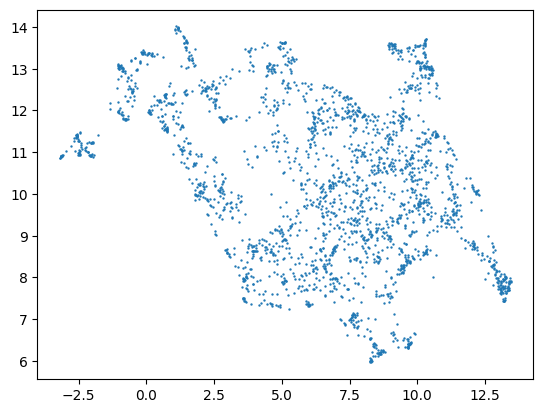

In [86]:
umap = UMAP(n_components=2)
data_2d_umap = umap.fit_transform(torch.flatten(latents, start_dim=1).cpu())
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d_umap[:, 0], data_2d_umap[:, 1], s=0.5)

# Show the plot
plt.show()

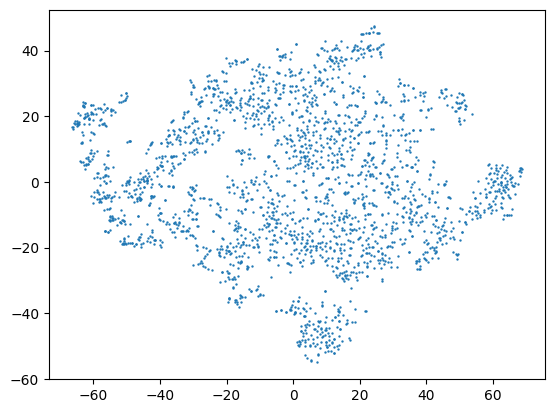

In [87]:
tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d_tsne = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], s=0.5)

# Show the plot
plt.show()

### deciding the number of clusters

In [53]:
def calculate_wcss(latents):
    wcss = []
    for n in tqdm(range(1, 10)):  # change the range according to your needs
        kmeans = KMeans(n_clusters=n)
        data = torch.flatten(latents, start_dim=1).cpu()
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the model
    return wcss
# calculate WCSS for different numbers of clusters
wcss = calculate_wcss(latents)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█████████▎                                                                          | 1/9 [00:02<00:22,  2.83s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██████████████████▋                                                                 | 2/9 [00:16<01:03,  9.01s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarni

In [54]:
wcss

[140844370.30205965,
 127569664.2244078,
 120802087.88574387,
 115997995.92661744,
 112439294.14965923,
 109102726.26657571,
 106594919.67873381,
 104687940.97144407,
 102984272.55135164]

In [55]:
# Convert list to DataFrame
wcss_df = pd.DataFrame(wcss)
wcss_df.to_csv('wcss_SF.csv',index=False)
wcss_df

,0
0,1.408444e+08
1,1.275697e+08
2,1.208021e+08
3,1.159980e+08
4,1.124393e+08
5,1.091027e+08
6,1.065949e+08
7,1.046879e+08
8,1.029843e+08


In [56]:
def plot_elbow(wcss, filename=None):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(wcss) + 1), wcss, 'bo-')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid()
    filename = 'elbow plot for k-means'
    plt.savefig(filename)

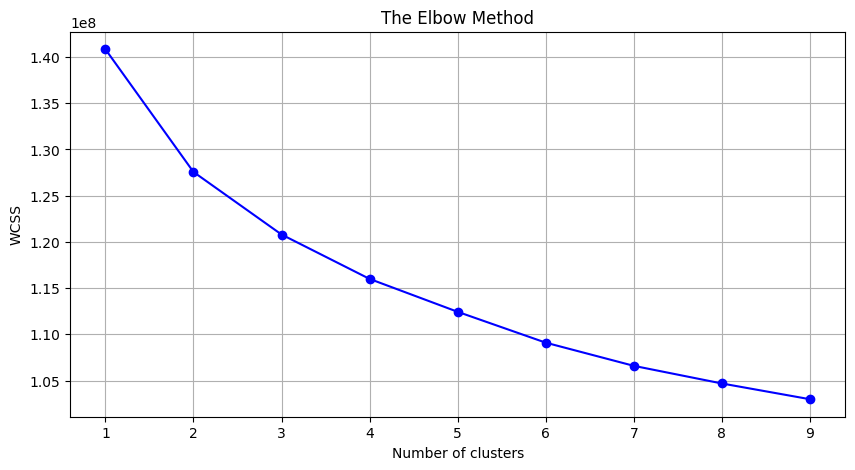

In [57]:
# plot the elbow graph
plot_elbow(wcss)

the number of clusters are set to 5, 10, 15

In [58]:
def calculate_slope(points):
    slopes = []
    for i in range(len(points) - 1):
        slope = (points[i + 1] - points[i]) / (i + 2 - i)
        slopes.append(slope)
    return slopes

def find_optimal_point(slopes, drop_threshold=0.1):
    optimal_point = 1
    for i in range(len(slopes)):
        if slopes[i] / slopes[i - 1] <= drop_threshold:
            optimal_point = i + 1
            break
    return optimal_point

In [59]:
# Calculate slopes
slopes = calculate_slope(wcss)
print(slopes)
# Find the optimal point based on the slope
optimal_point = find_optimal_point(slopes)

print("Optimal point:", optimal_point)

[-6637353.038825922, -3383788.169331968, -2402045.979563214, -1779350.8884791061, -1668283.9415417612, -1253903.293920949, -953489.3536448702, -851834.2100462168]
Optimal point: 1


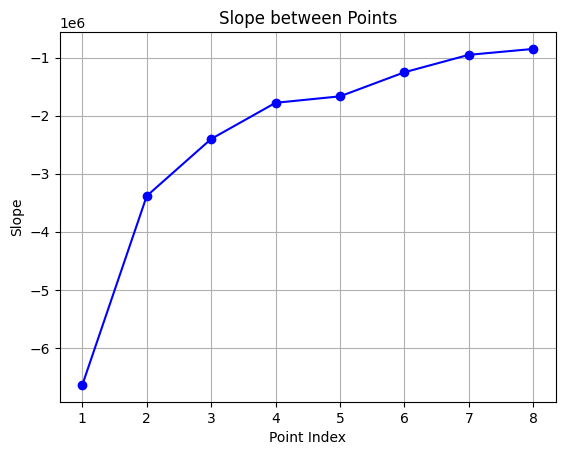

In [60]:
# Plot the slopes
plt.plot(range(1, len(wcss)), slopes, 'bo-')
plt.title('Slope between Points')
plt.xlabel('Point Index')
plt.ylabel('Slope')
plt.grid()
plt.show()

### Clustering

MF CLUSTER = 2 \
SF CLUSTER = 4

In [88]:
n_clusters=2
data_latent = latents # this is the data for clustering

In [89]:
#Initialize the class object
kmeans = KMeans(n_clusters=n_clusters)
data = torch.flatten(data_latent, start_dim=1).cpu()
# #predict the labels of clusters.
label = kmeans.fit_predict(data)
# get cluster centers
cluster_centers = kmeans.cluster_centers_
closest, _ = pairwise_distances_argmin_min(cluster_centers, data)
print(cluster_centers.shape, data.shape)



center_list = closest
print(center_list)
df = np.stack((label, floor.all_data_dirs)).transpose()
df = pd.DataFrame(df,columns=['label','data'])

C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(2, 25088) torch.Size([2419, 25088])
[ 56 341]


In [90]:
def calculate_index_png(index):
    image_path = floor.all_data_dirs[index]  # Replace with appropriate image paths list
    file_name, file_extension = os.path.splitext(image_path)
    num_index = int(os.path.basename(file_name))
    return num_index

In [91]:
# Save closest points and cluster centers to CSV
df_center = pd.DataFrame({'Cluster Center': cluster_centers.tolist(), 'Closest Point Index': closest})
df_center['index_png'] = df_center['Closest Point Index'].apply(lambda x: calculate_index_png(x))
df_center.to_csv(f'../results/MARL_{curr_data}_{n_clusters}cluster_centers.csv', index=False)

df_center_index = np.stack((label, floor.all_data_dirs)).transpose()
df_center_index = pd.DataFrame(df_center_index,columns=['label','data'])
df_center_index['index'] = df_center_index['data'].str.extract(r'(\d+).pt')
df_center_index = df_center_index.drop(['data'], axis=1)
df_center_index['index'] = df_center_index['index'].astype(int)
df_center_index.to_csv(f'../results/MARL_{curr_data}_{n_clusters}clusters_clusterindex.csv', index=False)
print(df_center_index.shape)
df_center_index.head(2)


(2419, 2)


,label,index
0,1,1010
1,0,1015


In [116]:
center_list = closest
center_list_annotation = df_center['index_png'].tolist()

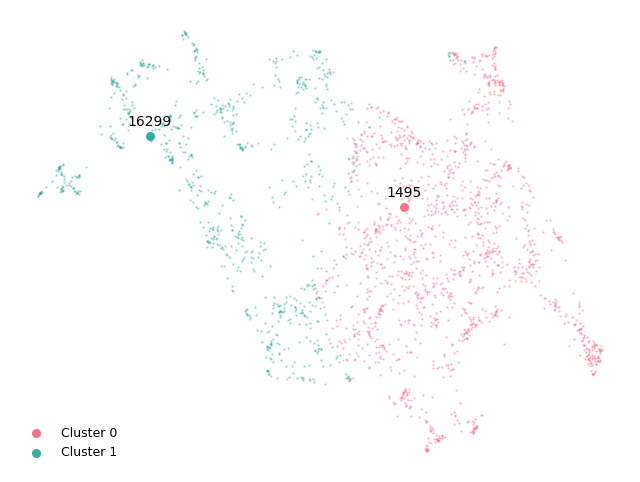

In [118]:
data_2d = data_2d_umap # this is the data for visualization
dim_name = 'umap'

#Getting unique labels
plt.figure(figsize=(8,6))
u_labels = np.unique(label)
num_labels = len(u_labels)
color_palette = sns.color_palette('husl', num_labels)
for i, each in enumerate(center_list):
    plt.scatter(data_2d[each][0],data_2d[each][1], s=30, c=[color_palette[i]])
    plt.annotate(center_list_annotation[i], (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label=f"Cluster {i}", s=0.5, c=[color_palette[i]],alpha=0.4)
legend = plt.legend(loc='lower left', ncol=1, frameon=False)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([30])  # Increase the size of legend dots    
    legend_handle.set_alpha(1)
plt.setp(legend.texts, fontsize='9')
plt.axis('off')
plt.savefig(f'MARL_{curr_data}_{dim_name}_{n_clusters}_kmeans.png')

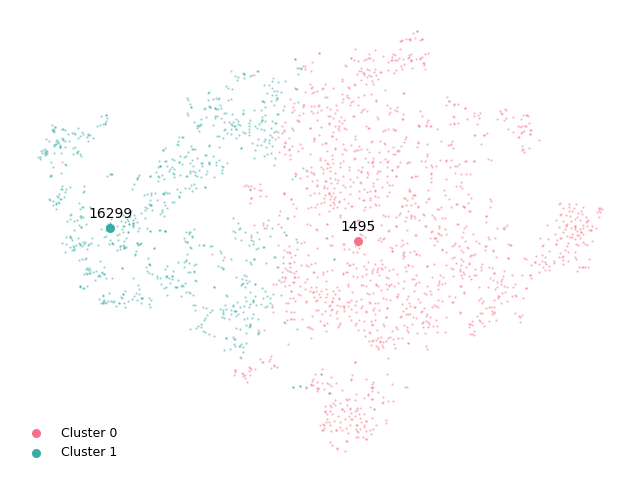

In [119]:
data_2d = data_2d_tsne # this is the data for visualization
dim_name = 'tsne'

#Getting unique labels
plt.figure(figsize=(8,6))
u_labels = np.unique(label)
num_labels = len(u_labels)
color_palette = sns.color_palette('husl', num_labels)
for i, each in enumerate(center_list):
    plt.scatter(data_2d[each][0],data_2d[each][1], s=30, c=[color_palette[i]])
    plt.annotate(center_list_annotation[i], (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label=f"Cluster {i}", s=0.5, c=[color_palette[i]],alpha=0.4)
legend = plt.legend(loc='lower left', ncol=1, frameon=False)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([30])  # Increase the size of legend dots 
    legend_handle.set_alpha(1)
plt.setp(legend.texts, fontsize='9')
plt.axis('off')
plt.savefig(f'MARL_{curr_data}_{dim_name}_{n_clusters}_kmeans.png')

## Visualize the cluster center

In [94]:
center_list

array([ 56, 341], dtype=int64)

In [95]:
# k_means_center = 
# n_clusters=5
# # data_2d = data_2d_umap
# # data = data_2d_umap
# cluster_count = n_clusters
# file_path = f"../results/clustercenter/umap_{cluster_count}cluster_centers.csv"
# indexes = pd.read_csv(file_path)['Closest Point Index'].tolist()
# indexes

In [96]:
def scale_crop(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.CenterCrop(56)])
    return rescale(img)

In [112]:
indexes = center_list
cluster_count = n_clusters

C:\Users\xinwei\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


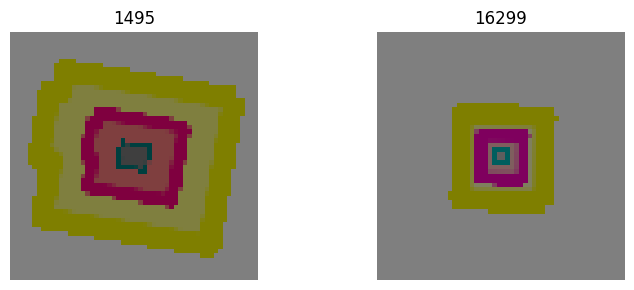

In [113]:
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Read the image using torch's load
    image = torch.load(image_path)
    scaled = scale_crop(image)
    # Display the image in the corresponding subplot
    image_array = scaled.permute(1, 2, 0).numpy()  # Convert to (56, 56, 3) shape
    axes[i].imshow(image_array, cmap='gray')
    axes[i].set_title(os.path.basename(image_path).split(".")[0])
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/MARL_{curr_data}_{cluster_count}cluster_sample_multiscale.png")

In [99]:
def get_zoomed_img(image_path, half_pixel):
    image = mpimg.imread(image_path)
    # Get the center coordinates
    height, width, _ = image.shape
    center_x = width // 2
    center_y = height // 2
    
    # Calculate the coordinates for the center 150x150 pixels
    x1 = center_x - half_pixel
    x2 = center_x + half_pixel
    y1 = center_y - half_pixel
    y2 = center_y + half_pixel
    
    # Extract the center 150x150 pixels from each image
    center_img = image[y1:y2, x1:x2]
    return center_img

[1495, 16299]

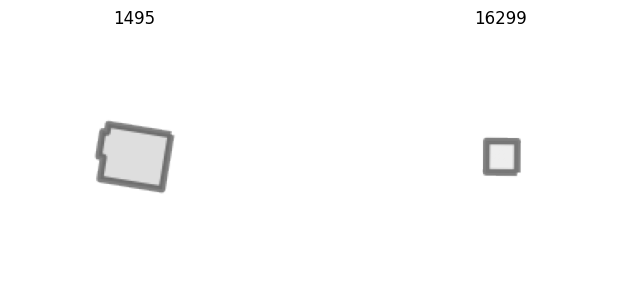

In [115]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cluster_count = n_clusters
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Define the new directory
new_dir = 'kmeans_5_cluster'
num_indexes = []
# Create the new directory if it doesn't exist
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Split the path into the name and the extension
    file_name, file_extension = os.path.splitext(image_path)
    # Replace the '.pt' extension with '.png'
    png_file_path = file_name + '.png'
    # Read the image data
    img = get_zoomed_img(png_file_path, 75)
    # Display the image in the corresponding subplot
    axes[i].imshow(img, cmap='gray')
    # Extract numerical part from the file name
    num_index = int(os.path.basename(file_name))
    num_indexes.append(num_index)
    axes[i].set_title(f"{num_index}")
    axes[i].axis('off')

    # Add the prefix 'VQVAE_' to the original filename
    basename = os.path.basename(file_name)
    # Add the prefix 'VQVAE_' to the basename
    new_basename = f'MARL_{curr_data}_{basename}.png'
    # Copy the PNG file to the new directory with the modified filename
    shutil.copy(png_file_path, os.path.join(new_dir, new_basename))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/MARL_{curr_data}_{cluster_count}cluster_sample.png")
num_indexes

In [101]:
indexes = num_indexes
indexes

[1495, 16299]

## calculate aggregated area

In [102]:
# metadata_file_path = r"..\data\data_root\building_metadata.csv"
# metadata_df = pd.read_csv(metadata_file_path)
# metadata_df_clean = metadata_df[['OBJECTID','vintage','idf.kw', 'FootprintArea.m2', 'building.area.m2', 'HEIGHT']]
# metadata_df_clean = metadata_df_clean[metadata_df_clean['idf.kw'].str.contains('Family')]
# metadata_df_clean.to_csv(r"..\data\data_root\building_metadata_clean.csv", index=None)

In [103]:
# metadata_file_path = r"..\data\data_root\building_metadata_clean.csv"
# metadata_df = pd.read_csv(metadata_file_path, index_col=False)
# metadata_df.head(5)

In [104]:
df_center_index

,label,index
0,1,1010
1,0,1015
2,1,1019
3,0,1029
4,1,1035
...,...,...
2414,0,966
2415,1,967
2416,1,972
2417,0,980


In [105]:
merged_df = pd.merge(df_center_index, metadata_df, left_on='index', right_on = 'OBJECTID', how='inner')
print(df_center_index.shape, merged_df.shape)
merged_df

(2419, 2) (2419, 8)


,label,index,OBJECTID,vintage,idf.kw,FootprintArea.m2,building.area.m2,HEIGHT
0,1,1010,1010,before 1980,MultiFamily-pre-1980,219.612523,332.3962,33.73
1,0,1015,1015,1981-2008 (2004),MultiFamily-2004,174.538913,231.5068,34.59
2,1,1019,1019,before 1980,MultiFamily-pre-1980,91.765997,136.8417,22.33
3,0,1029,1029,before 1980,MultiFamily-pre-1980,45.206293,55.4613,17.18
4,1,1035,1035,before 1980,MultiFamily-pre-1980,72.975285,87.1402,22.90
...,...,...,...,...,...,...,...,...
2414,0,966,966,before 1980,MultiFamily-pre-1980,108.068647,210.8830,32.68
2415,1,967,967,1981-2008 (2004),MultiFamily-2004,99.631505,161.8318,20.94
2416,1,972,972,1981-2008 (2004),MultiFamily-2004,165.700664,371.6000,27.36
2417,0,980,980,before 1980,MultiFamily-pre-1980,158.730095,254.1744,33.15


In [106]:
grouped_df_lab = merged_df.groupby('idf.kw')['building.area.m2'].sum().reset_index()
grouped_df_lab.to_csv(f"kmeans_5_cluster/MARL_{curr_data}_{cluster_count}cluster_area_aggregation_lab.csv")
grouped_df_lab

,idf.kw,building.area.m2
0,MultiFamily-2004,106609.4388
1,MultiFamily-2013,3983.2733
2,MultiFamily-pre-1980,750530.9248


In [107]:
grouped_df = merged_df.groupby('label')['building.area.m2'].sum().reset_index()
grouped_df['index'] = df_center['Closest Point Index']
grouped_df.to_csv(f"kmeans_5_cluster/MARL_{curr_data}_{cluster_count}cluster_area_aggregation.csv")
grouped_df

,label,building.area.m2,index
0,0,544287.1650,56
1,1,316836.4719,341


In [108]:
json_index = curr_data.split('_')[0].split('data')[1]
print(json_index)
json_df = gpd.read_file(f'../data/data_root/geojson_{json_index}.json', driver='GeoJSON')
json_df = json_df[['OBJECTID','BLD_ID', 'YearBuilt1', 'HEIGHT', 'footprint', 'UseType', 'UseDescription', 'Shape_Area_1', 'geometry']]
json_df

00


,OBJECTID,BLD_ID,YearBuilt1,HEIGHT,footprint,UseType,UseDescription,Shape_Area_1,geometry
0,37,503291745320,1977,22.26,1622.0,Residential,Three Units (Any Combination),4.425734e+03,"MULTIPOLYGON (((-118.19224 33.78813, -118.1922..."
1,40,509892745808,1923,9.92,356.0,Residential,Five or more apartments,8.903658e+03,"MULTIPOLYGON (((-118.17043 33.78950, -118.1703..."
2,43,503428745279,1927,18.32,909.0,Residential,Five or more apartments,7.405476e+03,"MULTIPOLYGON (((-118.19170 33.78794, -118.1917..."
3,46,502311745717,1977,21.89,2446.0,Residential,Four Units (Any Combination),7.503758e+03,"MULTIPOLYGON (((-118.19549 33.78922, -118.1952..."
4,52,498043745228,1938,11.64,644.0,Residential,Single,5.046112e+03,"MULTIPOLYGON (((-118.20936 33.78779, -118.2094..."
...,...,...,...,...,...,...,...,...,...
23041,25641,461445721376,1973,8.98,119.0,Residential,Mobile Home Parks,2.153294e+06,"MULTIPOLYGON (((-118.32959 33.72203, -118.3295..."
23042,25642,461246722265,1973,15.50,2349.0,Residential,Mobile Home Parks,2.153294e+06,"MULTIPOLYGON (((-118.33030 33.72436, -118.3303..."
23043,25643,461534722533,1973,12.66,3941.0,Residential,Mobile Home Parks,2.153294e+06,"MULTIPOLYGON (((-118.32922 33.72521, -118.3292..."
23044,25644,461667722638,1973,13.94,2445.0,Residential,Mobile Home Parks,2.153294e+06,"MULTIPOLYGON (((-118.32893 33.72540, -118.3289..."


In [109]:
df_center['Closest Point Index'] = num_indexes
df_center

,Cluster Center,Closest Point Index,index_png
0,"[1.2360807375614739e-05, 0.0002805631137588642...",1495,1495
1,"[0.0, 1.8973538018496328e-19, 7.58941520739853...",16299,16299


In [110]:
center_metadata =  pd.merge(df_center, json_df, left_on='Closest Point Index', right_on = 'OBJECTID', how='inner')
center_metadata

,Cluster Center,Closest Point Index,index_png,OBJECTID,BLD_ID,YearBuilt1,HEIGHT,footprint,UseType,UseDescription,Shape_Area_1,geometry
0,"[1.2360807375614739e-05, 0.0002805631137588642...",1495,1495,1495,507881737426,1909,25.60,1791.0,Residential,Single,5028.740034,"MULTIPOLYGON (((-118.17689 33.76647, -118.1769..."
1,"[0.0, 1.8973538018496328e-19, 7.58941520739853...",16299,16299,16299,528063748512,1953,13.51,478.0,Residential,Single,6596.919050,"MULTIPOLYGON (((-118.11058 33.79694, -118.1106..."


In [111]:
center_metadata.to_csv(f"kmeans_5_cluster/MARL_{curr_data}_{cluster_count}cluster_metadata.csv")

## recon the cluster center and export metadata

In [181]:
kmeans.cluster_centers_.shape

(5, 25088)

(82, 3, 112, 112) -> 

In [209]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 32, 28, 28).astype('float32')).to(device)

# def show(img, title):
#     npimg = img.numpy()
#     fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     fig.axes.set_title(title)
# plt.figure()  # Create a new plot
# show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
# plt.savefig(f"{n_clusters}_VQrecon.png", bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


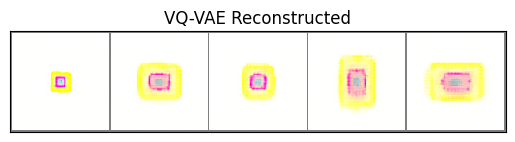

In [221]:
latent = vqae.pre_quantization_conv(latent_centers)
embedding_loss, latent, perplexity, _ = vqae.vector_quantization(latent)
x_hat = vqae.decoder(latent)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)
plt.figure()  # Create a new plot
show(torchvision.utils.make_grid(x_hat.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig(f"../results/recon_img/MARL_{curr_data}_{cluster_count}cluster_center_recon.png", bbox_inches='tight')

In [207]:
latent.shape

torch.Size([5, 64, 28, 28])

In [203]:
valid_recon = vqae.pre_quantization_conv(latent_centers)
valid_recon.shape

torch.Size([5, 64, 28, 28])

In [201]:
valid_recon[3].shape

torch.Size([1960, 218])

In [191]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 32, 28, 28).astype('float32')).to(device)
valid_recon = vqae.decoder(latent_centers)
valid_recon

RuntimeError: Given transposed=1, weight of size [64, 32, 3, 3], expected input[5, 32, 28, 28] to have 64 channels, but got 32 channels instead

# Visualize and Save Reconstruction Image

In [13]:
floor.all_data_dirs[8834]

'../data/data_root/data00/18753.pt'

In [188]:
kmeans.cluster_centers_.shape

(5, 25088)

In [190]:
64*14*14

12544

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


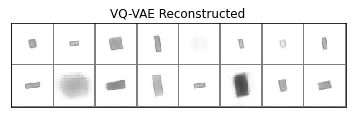

In [19]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 32, 28, 28).astype('float32')).to(device)
vqae.eval()
valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)
plt.figure()  # Create a new plot
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig(f"{n_clusters}_VQrecon.png", bbox_inches='tight')

In [20]:
def rescale_img(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.Pad(56, fill=1.0)])
    return rescale(img)
rescaled_recon = rescale_img(valid_recon+0.5)

for i in range(rescaled_recon.shape[0]):
    save_image(rescaled_recon[i], f'../results/recon_img/{n_clusters}cluster-img{i}.jpg')
    
print('save to results/recon_img/*.jpg')

save to results/recon_img/*.jpg


### For rhino mapping-back 

In [22]:
import glob
import cv2
import os
import numpy as np
import torchvision.transforms.functional as TF
import imageio
import matplotlib.pyplot as plt

In [23]:
folder_path = "../results/recon_img/"  
img_files = []
for filename in os.listdir(folder_path):
    if "5cluster" in filename:
        print(filename)
        img_files.append(filename)

5cluster-img0.jpg
5cluster-img0_rectangle.jpg
5cluster-img1.jpg
5cluster-img1_rectangle.jpg
5cluster-img2.jpg
5cluster-img2_rectangle.jpg
5cluster-img3.jpg
5cluster-img3_rectangle.jpg
5cluster-img4.jpg
5cluster-img4_rectangle.jpg


In [24]:
def calc_height(image_path):
    print(image_path)
    fullpath = f"../results/recon_img/"+str(image_path)
    image = cv2.imread(fullpath)
    height, width, channels = image.shape
    print(height, width, channels)
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = image[start:end, start:end, :]
    average_pixel_value = np.mean(central_region, axis=(0,1))
    
    # Draw a red rectangle around the central region
    img_with_rectangle = np.copy(image)
    cv2.rectangle(img_with_rectangle, (start, start), (end, end), (0, 0, 255), 2)  # Draw red rectangle
    
    # Save the image with the red rectangle
    image_with_rectangle_path = fullpath.replace(".jpg", "_rectangle.jpg")  # Update the path as per your requirement
    imageio.imwrite(image_with_rectangle_path, img_with_rectangle)
    print(image_with_rectangle_path)
    return average_pixel_value

central_region_size = 10
height_info = []
for image_path in img_files:
    average_pixel_value = calc_height(image_path)
    height_info.append(average_pixel_value[0])

5cluster-img0.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle.jpg
5cluster-img0_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle_rectangle.jpg
5cluster-img1.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle.jpg
5cluster-img1_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle_rectangle.jpg
5cluster-img2.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle.jpg
5cluster-img2_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle_rectangle.jpg
5cluster-img3.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle.jpg
5cluster-img3_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle_rectangle.jpg
5cluster-img4.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle.jpg
5cluster-img4_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle_rectangle.jpg


In [25]:
height_info

[170.12, 206.37, 176.69, 209.12, 132.11, 187.8, 177.97, 206.41, 213.68, 217.87]

In [26]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)

### get aggregated area

In [72]:
def get_csv_df(index):
    desired_number = str(index)
    for filename in os.listdir(directory_path):
        if desired_number in filename:
            file_path = os.path.join(directory_path, filename)
            csv_df = pd.read_csv(file_path,index_col=None)
            csv_df['index'] = csv_df['data'].str.extract(r'(\d+)\.pt')
            csv_df['index']=csv_df['index'].astype(int)
    return csv_df

In [104]:
def calculate_aggregated_areas(csv_df):
    desired_features = []
    for feature in jsonfile['features']:
        if feature['properties']['OBJECTID'] in csv_df['index'].values:
            desired_features.append(feature)

    # Extract information for objectID, areas, and heights from desired features
    objectID_list = []
    footprint_list = []
    area_list = []
    height_list = []

    for feature in desired_features:
        objectID = feature['properties']['OBJECTID']
        footprint = feature['properties']['footprint']
        area = feature['properties']['Shape_Area_1']
        height = feature['properties']['HEIGHT']

        objectID_list.append(objectID)
        footprint_list.append(footprint)
        area_list.append(area)
        height_list.append(height)

        # Create a new DataFrame from the extracted information
        json_df = pd.DataFrame({
            'objectID': objectID_list,
            'footprint': footprint_list,
            'area': area_list,
            'height': height_list
        })
    merged_df = json_df.merge(csv_df, left_on='objectID', right_on='index')
    sum_of_area = merged_df['area'].sum()
    return sum_of_area, merged_df

In [125]:
def get_sum_of_area():
    merged_df = csv_df.merge(objectid_ref_df, left_on='index', right_on='OBJECTID')
    print(f"csv_df shape = {csv_df.shape}, objectid_ref_df = {objectid_ref_df.shape}")
    print(f"merged_df shape = {merged_df.shape}")
    sum_of_area = merged_df['building.area.m2'].sum()
    return sum_of_area

In [126]:
sum_of_area_list = []
json_file_path = r"..\data\data_root\geojson_0.json"
directory_path = r'../results/area_aggregation'  # Use r prefix for raw string
# Create an empty DataFrame to store the objectIDs
objectID_df = pd.DataFrame(columns=[0])
# Load the JSON data from the file
with open(json_file_path) as file:
    jsonfile = json.load(file)
    
for index in tqdm(num_indexes):
    csv_df = get_csv_df(index)
    # filtered_df = csv_df[csv_df['index'].isin(objectid_ref_df['OBJECTID'])]
    # print(filtered_df.shape)
    # sum_of_area, merged_df=calculate_aggregated_areas(filtered_df)
    sum_of_area = get_sum_of_area()
    sum_of_area_list.append(sum_of_area)
    # merged_df.to_csv(f'../results/area_aggregation/5cluster_{index}_merged.csv',index=False)
    # objectID_df = pd.concat([objectID_df, merged_df['objectID']], ignore_index=True)
# objectID_df.to_csv('../results/area_aggregation/objectID.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.52it/s]

csv_df shape = (4259, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4259, 12)
csv_df shape = (2730, 7), objectid_ref_df = (13367, 5)
merged_df shape = (2730, 12)
csv_df shape = (852, 7), objectid_ref_df = (13367, 5)
merged_df shape = (852, 12)
csv_df shape = (4423, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4423, 12)
csv_df shape = (1105, 7), objectid_ref_df = (13367, 5)
merged_df shape = (1105, 12)


In [129]:
sum_of_area_list

[1141716.3815,
 728261.4942000001,
 243567.91410000002,
 1193941.6029,
 291030.5241]

In [113]:
objectid_ref_df

,Unnamed: 0,OBJECTID,idf.kw,FootprintArea.m2,building.area.m2
0,11,37,SingleFamily-pre-1980,91.316398,69.3963
1,14,46,SingleFamily-2004,99.909763,193.0462
2,20,52,MultiFamily-pre-1980,94.014890,189.7018
3,24,57,SingleFamily-pre-1980,341.028058,314.1878
4,28,63,SingleFamily-2004,268.205501,325.5216
...,...,...,...,...,...
13362,15476,25638,SingleFamily-pre-1980,227.679816,121.2345
13363,15477,25642,MultiFamily-pre-1980,62.026620,262.0709
13364,15478,25643,MultiFamily-2004,129.942767,464.5000
13365,15479,25644,SingleFamily-pre-1980,164.018356,176.6958


In [114]:
objectid_ref_df.sum()

Unnamed: 0                                                  107901183
OBJECTID                                                    187510622
idf.kw              SingleFamily-pre-1980SingleFamily-2004MultiFam...
FootprintArea.m2                                       3274820.381714
building.area.m2                                          3597987.272
dtype: object

In [130]:
sum_of_area_list

[1141716.3815,
 728261.4942000001,
 243567.91410000002,
 1193941.6029,
 291030.5241]

In [132]:
new_df = pd.DataFrame({'index': num_indexes, 'area': sum_of_area_list})
new_df.to_csv('area_aggregation_kmeans_5.csv')